In [1]:

# importar as bibliotecas necessãrias
import zipfile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from googletrans import Translator
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#carrega arquivo csv em um dataframe
df_PIB = pd.read_csv('C:/Users/fidel/Dropbox/Pós Insper Data Science/MDCD/PIB_Estados_2019.csv', sep=';', encoding='latin1')

#Trocar o nome da coluna Unidades da Federação para Estado
df_PIB.rename(columns={'Unidades da Federação': 'Estado'}, inplace=True)
#Trocar o nome da colina PIB em 2021 (1.000.000 R$) para PIB   
df_PIB.rename(columns={'PIB em 2021 (1.000.000 R$)': 'PIB'}, inplace=True)
#converter a coluna PIB para float
df_PIB['PIB'] = df_PIB['PIB'].str.replace('.','')  #troca virgula por ponto
df_PIB['PIB'] = df_PIB['PIB'].astype(float) #converte para float
df_PIB.head()

,Estado,PIB
0,AC,15630.0
1,AL,58964.0
2,AP,17497.0
3,AM,108181.0
4,BA,293241.0


In [3]:
# Caminho da pasta compactada
caminho_pasta_zipada = "C:/Users/fidel/Dropbox/Pós Insper Data Science/MDCD/Dados - Olist.zip"

In [4]:
# Extrair todos os arquivos da pasta compactada para uma pasta temporária
pasta_temporaria = "pasta_temporaria"
with zipfile.ZipFile(caminho_pasta_zipada, 'r') as zip_ref:
    zip_ref.extractall(pasta_temporaria)

In [5]:
# Listar todos os arquivos na pasta temporária
arquivos_na_pasta = os.listdir(pasta_temporaria)
print(arquivos_na_pasta)
print(pasta_temporaria)

['Dados - Olist']
pasta_temporaria


In [6]:
# Diretório contendo os arquivos CSV
diretorio = 'C:/Users/fidel/Dropbox/Pós Insper Data Science/MDCD/'+pasta_temporaria+'/'+arquivos_na_pasta[0]+'/'

# Lista para armazenar os nomes dos arquivos CSV
arquivos_csv = os.listdir(diretorio)

# Dicionário para armazenar os DataFrames
dataframes = {}

# Loop sobre cada arquivo CSV
for arquivo in arquivos_csv:
    # Verifica se é um arquivo CSV
    if arquivo.endswith('.csv'):
        # Constrói o caminho completo do arquivo
        caminho_arquivo = os.path.join(diretorio, arquivo)
        # Lê o arquivo CSV e armazena no DataFrame correspondente
        nome_dataframe = os.path.splitext(arquivo)[0]  # Remove a extensão .csv
        dataframes[nome_dataframe] = pd.read_csv(caminho_arquivo)

In [7]:
base_dados = list(dataframes.keys())
base_dados

['olist_customers_dataset',
 'olist_geolocation_dataset',
 'olist_orders_dataset',
 'olist_order_items_dataset',
 'olist_order_payments_dataset',
 'olist_order_reviews_dataset',
 'olist_products_dataset',
 'olist_sellers_dataset',
 'product_category_name_translation']

In [8]:
customers = dataframes[base_dados[0]]
geolocation = dataframes[base_dados[1]]
orders = dataframes[base_dados[2]]
order_items = dataframes[base_dados[3]]
order_payments = dataframes[base_dados[4]]
order_reviews = dataframes[base_dados[5]]
products = dataframes[base_dados[6]]
sellers = dataframes[base_dados[7]]


In [9]:
# 1 Quantas linhas temos na tabela orders?
orders.shape[0]

99441

In [10]:
# 2 Quantas linhas temos na tabela orders_items?
order_items.shape[0]

112650

In [11]:
# 3 Quantas linhas temos na tabela customers?
customers.shape[0]

99441

In [12]:
# 4 Quantas linhas temos na tabela sellers?
sellers.shape[0]

3095

In [13]:
# 5 Quantas linhas temos na tabela products?
products.shape[0]

32951

In [14]:
# 6 Quantas linhas temos na tabela payments?
order_payments.shape[0]

103886

In [15]:
# 7 Quantas linhas temos na tabela orders_reviews?
order_reviews.shape[0]

99224

In [16]:
# 8 Quantas linhas temos na tabela geolocation?
geolocation.shape[0]

1000163

In [17]:
# 9 quantos CEP unicos temos na tabela geolocation?
geolocation['geolocation_zip_code_prefix'].nunique()

19015

In [18]:
# 10 Quantas latitudes e longitudes estão expressas no geolocation?
geolocation['geolocation_lat'].nunique(), geolocation['geolocation_lng'].nunique()

(717360, 717613)

In [19]:
# 11 Crie um metodo para agrupar todas as diferentes latitudes e longitudes que um determinado CEP possui para um valor unico por CEP. Dica Use a funcao group_by e aggragate
geolocation_agrupado = geolocation.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'mean', 'geolocation_lng':'mean'}).reset_index()
geolocation_agrupado.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


In [20]:
# Transformando as colunas de data (de object para data)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])

orders['prazo_estimado'] = (orders['order_estimated_delivery_date'] - orders['order_approved_at']).dt.days
orders['prazo_realizado'] = (orders['order_delivered_customer_date'] - orders['order_approved_at']).dt.days
orders['atraso'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days

#Calculando o prazo médio de entrega
print(f"Prazo estimado médio: {orders.prazo_estimado.mean()}")
print(f"Prazo realizado médio: {orders.prazo_realizado.mean()}")
print(f"Atraso médio: {orders.atraso.mean()}")

Prazo estimado médio: 22.886262225400632
Prazo realizado médio: 11.642968215463084
Atraso médio: -11.876881296902857


In [21]:
# 12 mesclando os dataframes
#Mesclando os df de orders e customers
df = pd.merge(orders, customers, on='customer_id', how='left')
#Mesclando os df de orders e items
df = pd.merge(df, order_items, on='order_id', how='left')
#Mesclando os df de orders e sellers
df = pd.merge(df, sellers, on='seller_id', how='left')
#Mesclando os df de orders e payments
df = pd.merge(df, order_payments, on='order_id', how='left')
#Mesclando os df de orders e reviews
df = pd.merge(df, order_reviews, on='order_id', how='left')
#Mesclando os df de orders e products
df = pd.merge(df, products, on='product_id', how='left')
#Mesclando os df de orders e geolocation (customer = geolocation_zip_code_prefix_x)
df = pd.merge(df, geolocation_agrupado, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix' , how='left')
#Mesclando os df de orders e geolocation (seller = geolocation_zip_code_prefix_y)
#df = pd.merge(df, geolocation, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix' , how='left')

In [22]:
# 13 Quantas ordens distintas temos em nosso banco de dados?
df['order_id'].nunique()

99441

In [23]:
# 14 Quantos clientes distintos existem em nosso banco de dados?
df['customer_id'].nunique()

99441

In [24]:
# 15 Quantos vendedores distintos existem em nosso bando de dados?
df['seller_id'].nunique()

3095

In [25]:
# 16 Qual a porcentagem de vendas feitas com cartao de credito?
# 17 Qual a porcentagem de vendas feitas com cartao de debito?
df['payment_type'].value_counts(normalize=True)*100


payment_type
credit_card    73.674668
boleto         19.464496
voucher         5.426389
debit_card      1.431929
not_defined     0.002518
Name: proportion, dtype: float64

In [26]:
# 16.1 Qual a porcentagem do valor das vendas feitas com cartao de credito?
# 17.1 Qual a porcentagem do valor das vendas feitas com cartao de debito?
df.groupby('payment_type')['payment_value'].sum()/df['payment_value'].sum()*100


payment_type
boleto         19.975646
credit_card    76.655530
debit_card      1.250627
not_defined     0.000000
voucher         2.118197
Name: payment_value, dtype: float64

In [27]:
#18 Qual a porcentagem de reviews com 2 estrelas temos em nossa base?
df['review_score'].value_counts(normalize=True)*100


review_score
5.0    56.153403
4.0    18.891033
1.0    13.058419
3.0     8.374384
2.0     3.522760
Name: proportion, dtype: float64

In [28]:
#19 Quantas categorias de produto distintas existem em nossa base?
df['product_category_name'].nunique()

73

In [29]:
#20 Qual a média de review por categoria de produto?
review_produtos = df.groupby('product_category_name')['review_score'].mean().sort_values(ascending=False)
review_produtos

product_category_name
cds_dvds_musicais                                4.642857
fashion_roupa_infanto_juvenil                    4.500000
livros_interesse_geral                           4.438503
flores                                           4.419355
livros_importados                                4.419355
                                                   ...   
moveis_escritorio                                3.526791
portateis_cozinha_e_preparadores_de_alimentos    3.266667
fraldas_higiene                                  3.256410
pc_gamer                                         3.100000
seguros_e_servicos                               2.500000
Name: review_score, Length: 73, dtype: float64

In [30]:
# 21 Quais as 5 categorias que mais possuem produtos em nossa base?
df['product_category_name'].value_counts().head(5)

product_category_name
cama_mesa_banho           11988
beleza_saude              10032
esporte_lazer              9004
moveis_decoracao           8832
informatica_acessorios     8150
Name: count, dtype: int64

In [31]:
#22 Quantos comentarios existem na base?
df['review_comment_message'].count()


50245

In [32]:
# Quantos comentários únicos existem na base?
df['review_comment_message'].nunique()

36159

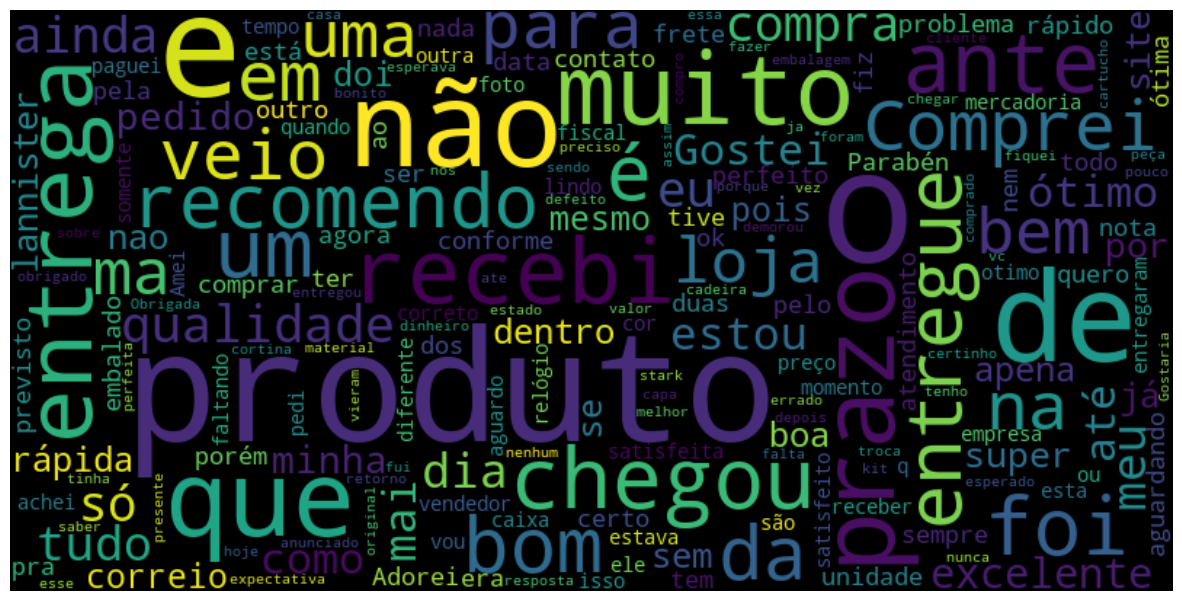

In [33]:
# 23 Crie uma nuvem de palavras que mostre as principais informacoes contidadas nos comentarios
reviews = df['review_comment_message'].dropna()
reviews = ' '.join(reviews)
wordcloud = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(reviews)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [34]:
# 24 Qual a porcentagem de ordens entregues?
df['order_status'].value_counts(normalize=True)*100

order_status
delivered      97.129500
shipped         1.054195
canceled        0.629496
unavailable     0.547242
invoiced        0.317266
processing      0.315587
created         0.004197
approved        0.002518
Name: proportion, dtype: float64

In [35]:
# 25 Qual o tempo medio entre a compra e a aprovacao da compra?

df['tempo_aprovacao'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days
df['tempo_aprovacao'].mean()

0.2744649731856161

In [36]:
# 26 Qual o tempo medio entre a compra e a entrega?
df['tempo_entrega'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['tempo_entrega'].mean()

12.022588617548953

In [37]:
# tempo medio entre a compra e a entrega por estado
tempo_entrega_estado = df.groupby('customer_state')['tempo_entrega'].mean().sort_values(ascending=False)
tempo_entrega_estado

customer_state
RR    27.826087
AP    27.662651
AM    26.064706
AL    24.128090
PA    23.268004
MA    21.191981
SE    20.886010
CE    20.344415
AC    20.170213
PB    20.107372
RO    19.234875
RN    19.184725
PI    18.893502
BA    18.734684
PE    17.765217
MT    17.522181
TO    16.664671
ES    15.235116
MS    15.057783
GO    14.903967
RJ    14.774957
RS    14.703888
SC    14.513443
DF    12.501430
PR    11.523074
MG    11.499963
SP     8.274160
Name: tempo_entrega, dtype: float64

In [38]:
# 27 Qual a diferenca media entre a data prevista de entrega e a data efetiva de entrega?
df['atraso'].mean()

-12.04839183560602

In [39]:
# 28 Em qual periodo do dia as pessoas mais costumam fazer compras por estado? Divida entre manha, tarde e noite.
df['periodo_compra'] = df['order_purchase_timestamp'].dt.hour
df['periodo_compra'] = pd.cut(df['periodo_compra'], bins=[0, 6, 12, 18, 24], labels=['madrugada', 'manha', 'tarde', 'noite'])
df.groupby('periodo_compra')['customer_state'].value_counts(normalize=True).unstack().idxmax()


customer_state
AC    madrugada
AL    madrugada
AM        tarde
AP    madrugada
BA    madrugada
CE        manha
DF        tarde
ES        manha
GO        tarde
MA    madrugada
MG        manha
MS        tarde
MT        manha
PA    madrugada
PB    madrugada
PE    madrugada
PI        manha
PR        tarde
RJ    madrugada
RN        manha
RO    madrugada
RR        tarde
RS        noite
SC        noite
SE    madrugada
SP    madrugada
TO        manha
dtype: object

In [40]:
# 29 Quais os diferentes tipos de dados temos em nossa tabela?
df.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
prazo_estimado                          float64
prazo_realizado                         float64
atraso                                  float64
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           

In [41]:
# 30 Quantos clientes distintos temos por estado?
df.groupby('customer_state')['customer_id'].nunique().sort_values(ascending=False)

customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_id, dtype: int64

In [42]:
# 31 Quantos vendedores distintos temos por estado?
df.groupby('customer_state')['seller_id'].nunique().sort_values(ascending=False)

customer_state
SP    2549
RJ    1751
MG    1664
RS    1232
PR    1232
SC    1038
BA     967
DF     786
ES     738
GO     724
PE     638
CE     528
MT     465
PA     465
MS     404
MA     375
PB     303
PI     297
RN     275
AL     252
SE     212
TO     199
RO     182
AM     118
AC      71
AP      63
RR      39
Name: seller_id, dtype: int64

In [43]:
# Crie uma coluna com a regiao metropolitana de São Paulo (região metrolpolitana de SP é considerada para prefixo de CEPs menores que 10000)
df['regiao_metropolitana_SP'] = np.where(df['customer_zip_code_prefix'] < 10000, 'Grande Sao Paulo', 'Outros')
# 32 Quantos clientes distintos temos na regiao metropolitana de Sao Paulo?
df[df['regiao_metropolitana_SP'] == 'Grande Sao Paulo']['customer_id'].nunique()


23995

In [44]:
# 33 Qual a media de valor, por estado, que os clientes atribuem aos vendedores?
df.groupby('customer_state')['review_score'].mean().sort_values(ascending=False)


customer_state
AP    4.240964
TO    4.138643
SP    4.108609
AC    4.094737
PR    4.087130
AM    4.070175
MG    4.068543
MS    4.054651
RN    4.049296
RS    4.027184
PB    3.992101
SC    3.988861
DF    3.987981
RO    3.979381
GO    3.975710
ES    3.974656
PE    3.957469
MT    3.890277
PI    3.849123
CE    3.810167
BA    3.807235
RJ    3.799830
SE    3.795511
PA    3.786101
AL    3.715835
MA    3.670588
RR    3.576923
Name: review_score, dtype: float64

In [45]:
# 34 Qual o valor medio de frete cobrado por estado ordenado do maior para o menor:
df.groupby('customer_state')['freight_value'].mean().sort_values(ascending=False)

customer_state
PB    43.228984
RR    42.984423
RO    40.970175
AC    40.021684
TO    39.677286
PI    39.201847
MA    38.200931
SE    36.627935
PA    35.649377
AL    35.643680
RN    35.270490
AP    34.084405
AM    33.045233
PE    32.717201
CE    32.457879
MT    28.953218
BA    26.297048
MS    23.350993
GO    22.747387
ES    21.976708
RS    21.806349
SC    21.444302
RJ    21.094054
DF    21.051144
MG    20.609697
PR    20.585367
SP    15.191519
Name: freight_value, dtype: float64

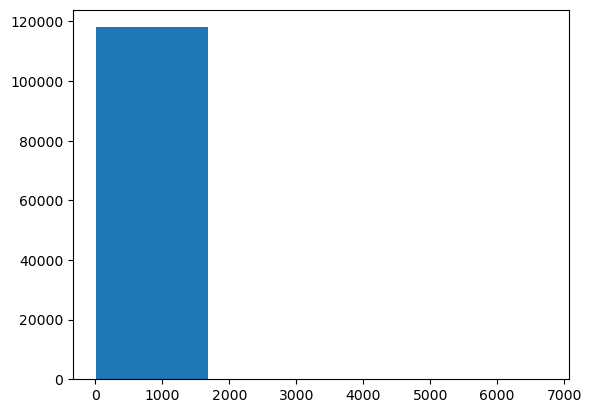

In [46]:
# 35 Faça um histograma de precos divididos em 4 quantis.
plt.hist(df['price'], bins=4)
plt.show()


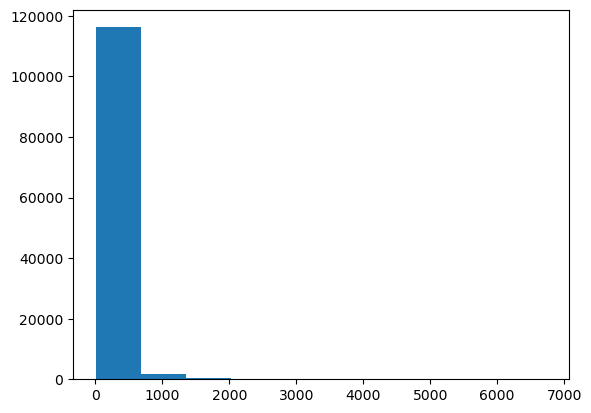

In [47]:
# 36 Trace um histograma de preços divididos em 10 quantis
plt.hist(df['price'], bins=10)
plt.show()

In [48]:
# 37 Qual a porcentagem de vendas é feita no estado de São Paulo e estão no primeiro quartil?
df['quartil'] = pd.qcut(df['payment_value'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
q1_SP = df[(df['customer_state'] == 'SP') & (df['quartil'] == 'Q1')].shape[0]/df.shape[0]*100
q1_SP

12.60502085728914

In [49]:
# 38 Qual o valor medio das compras no primeiro quartil?
media_q1 = df[df['quartil'] == 'Q1']['payment_value'].mean()
media_q1

38.73834708803006

In [50]:
# 39 Considerando uma base de 6.000.000 de clientes na Olist, qual a quantidade de clientes no primeiro quartil e de Sao Paulo podemos atingir?
q1_SP * 6000000/100


756301.2514373484

In [51]:
# 40 Qual o TAM (Tamanho de Mercado) no contexto descrito anteriormente?
media_q1 * q1_SP/100 * 6000000

29297860.3812915

In [52]:
# percentual de reviews com nota 1 por estado 
df['review_score_1'] = np.where(df['review_score'] == 1, 1, 0)
df.groupby('customer_state')['review_score_1'].mean().sort_values(ascending=False)

customer_state
RR    0.211538
MA    0.196262
SE    0.186104
RJ    0.185269
AL    0.183190
PA    0.168291
CE    0.166773
PI    0.157986
BA    0.157174
MT    0.147527
PE    0.145331
DF    0.136725
ES    0.135593
SC    0.132566
RS    0.127948
GO    0.126926
PB    0.125776
MS    0.122970
RN    0.120209
MG    0.117881
PR    0.113520
SP    0.110116
RO    0.102740
AM    0.092486
TO    0.082353
AC    0.073684
AP    0.047619
Name: review_score_1, dtype: float64

In [53]:
# Criar um dataframe com os dados de compras de clientes do RJ
df_rj = df[df['customer_state'] == 'RJ']
df_rj.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,prazo_estimado,prazo_realizado,...,product_width_cm,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,tempo_aprovacao,tempo_entrega,periodo_compra,regiao_metropolitana_SP,quartil,review_score_1
9,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,21.0,9.0,...,17.0,26525.0,-22.805707,-43.423079,0.0,9.0,tarde,Outros,Q2,0
13,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07,21.0,12.0,...,39.0,20780.0,-22.896463,-43.272172,0.0,12.0,noite,Outros,Q4,1
14,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07,21.0,12.0,...,39.0,20780.0,-22.896463,-43.272172,0.0,12.0,noite,Outros,Q4,1
20,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06,34.0,17.0,...,50.0,21381.0,-22.879075,-43.314672,0.0,17.0,noite,Outros,Q4,0
31,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,delivered,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-03-21 22:03:54,2018-03-12,17.0,27.0,...,22.0,21715.0,-22.879477,-43.440264,1.0,28.0,noite,Outros,Q3,0


In [54]:
# tempo de entrega médio do vendendor por estado no df_rj
tempo_entrega_vendedor_estado = df_rj.groupby('seller_state')['tempo_entrega'].mean().sort_values(ascending=False)
tempo_entrega_vendedor_estado

seller_state
RN    27.000000
RO    19.000000
CE    16.800000
MA    16.604651
PR    16.423509
SP    15.701832
SC    15.604651
MT    14.642857
PB    14.222222
MG    14.060940
DF    13.887850
GO    13.875000
PE    13.685185
RS    13.658451
BA    12.677083
ES    11.866667
MS    11.000000
SE     8.000000
RJ     6.083407
PI          NaN
Name: tempo_entrega, dtype: float64

In [55]:
# Maiores vendedores para o RJ (df_rj)
estados_vendedores = df_rj.groupby('seller_state')['payment_value'].sum().sort_values(ascending=False)
estados_vendedores

seller_state
SP    1794386.83
RJ     239936.21
MG     224432.92
PR     218598.19
SC     108940.89
RS      65508.67
BA      44554.25
PE      17995.79
ES      17970.64
DF      16831.42
GO       7988.01
PB       6840.87
MA       4838.05
CE       4514.32
MT       2758.15
MS       2025.90
RO       1906.97
RN        908.92
PI        173.77
SE        128.08
Name: payment_value, dtype: float64

In [56]:
# custo médio do frete por estado no df_rj
frete_estado = df_rj.groupby('seller_state')['freight_value'].mean().sort_values(ascending=False)
frete_estado

seller_state
CE    59.746000
PB    56.676000
RO    53.495000
SE    38.180000
RN    35.010000
PI    34.770000
MT    33.793571
BA    31.511735
MA    29.701628
RS    28.138611
SC    26.520000
ES    26.111688
PE    25.536727
GO    24.652727
MG    24.522997
PR    22.520647
MS    22.004444
DF    20.750357
SP    20.631615
RJ    12.369075
Name: freight_value, dtype: float64

In [57]:
# Media do preço do frete por peso por estado no df_rj
df_rj['frete_por_peso'] = df_rj['freight_value']/df_rj['product_weight_g']
frete_peso = df_rj.groupby('seller_state')['frete_por_peso'].mean().sort_values(ascending=False)
frete_peso

C:\Users\fidel\AppData\Local\Temp\ipykernel_16216\3931529577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rj['frete_por_peso'] = df_rj['freight_value']/df_rj['product_weight_g']


seller_state
GO    0.073574
MA    0.070908
PB    0.060762
DF    0.060386
PR    0.052712
RS    0.050981
PE    0.049957
BA    0.047097
SP    0.037229
SC    0.033885
MG    0.033299
RJ    0.029348
PI    0.028975
MT    0.028861
SE    0.027271
RO    0.024486
CE    0.017266
RN    0.016679
ES    0.009684
MS    0.008932
Name: frete_por_peso, dtype: float64

In [58]:
#Review médio por estado vendedor no df_rj
review_vendedor = df_rj.groupby('seller_state')['review_score'].mean().sort_values(ascending=False)
review_vendedor

seller_state
RO    5.000000
MS    4.888889
PB    4.555556
CE    4.500000
GO    4.375000
MA    4.309524
RJ    4.217693
BA    4.061856
RS    4.010676
SE    4.000000
MT    4.000000
MG    3.979330
SC    3.899281
ES    3.896104
PE    3.754717
PR    3.751489
SP    3.731594
DF    3.729730
RN    3.000000
PI    1.000000
Name: review_score, dtype: float64

In [59]:
#A desvio padrão do Review por estado vendedor no df_rj
desvio_review_vendedor = df_rj.groupby('seller_state')['review_score'].std().sort_values(ascending=False)
desvio_review_vendedor


seller_state
RN    2.828427
PR    1.587707
SP    1.577198
MT    1.568929
DF    1.566385
ES    1.518174
RS    1.498771
SC    1.494952
PE    1.492361
MG    1.437326
BA    1.352578
RJ    1.345117
PB    1.333333
CE    1.269296
MA    1.239357
GO    1.227981
MS    0.333333
RO    0.000000
PI         NaN
SE         NaN
Name: review_score, dtype: float64

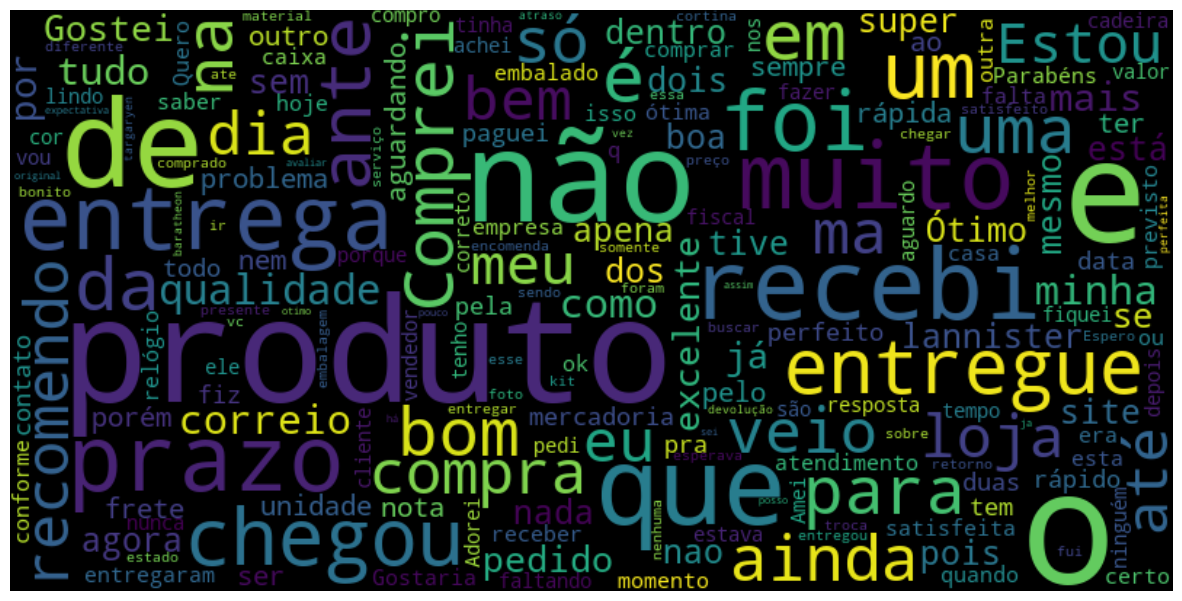

In [60]:
# Nuvem de palavras dos comentários dos clientes do RJ no df_rj
reviews_rj = df_rj['review_comment_message'].dropna()
reviews_rj = ' '.join(reviews_rj)
wordcloud = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(reviews_rj)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [61]:
#quais são os comentários mais comuns dos clientes do RJ no df_rj
reviews_rj = df_rj['review_comment_message'].dropna()
reviews_rj.value_counts().head(10)


review_comment_message
Muito bom               33
Bom                     31
Recomendo               18
Excelente               16
bom                     15
Não recebi o produto    13
otimo                   12
Ótimo                   11
Recomendo               10
recomendo               10
Name: count, dtype: int64

In [62]:
reviews_title_rj = df_rj['review_comment_title'].dropna()
reviews_title_rj.value_counts().head(15)

review_comment_title
Recomendo          66
Bom                59
Excelente          40
recomendo          38
Muito bom          38
super recomendo    32
Ótimo              32
Super recomendo    23
Ótimo              22
Ruim               19
Otimo              18
Excelente          18
10                 18
RECOMENDO          16
bom                14
Name: count, dtype: int64

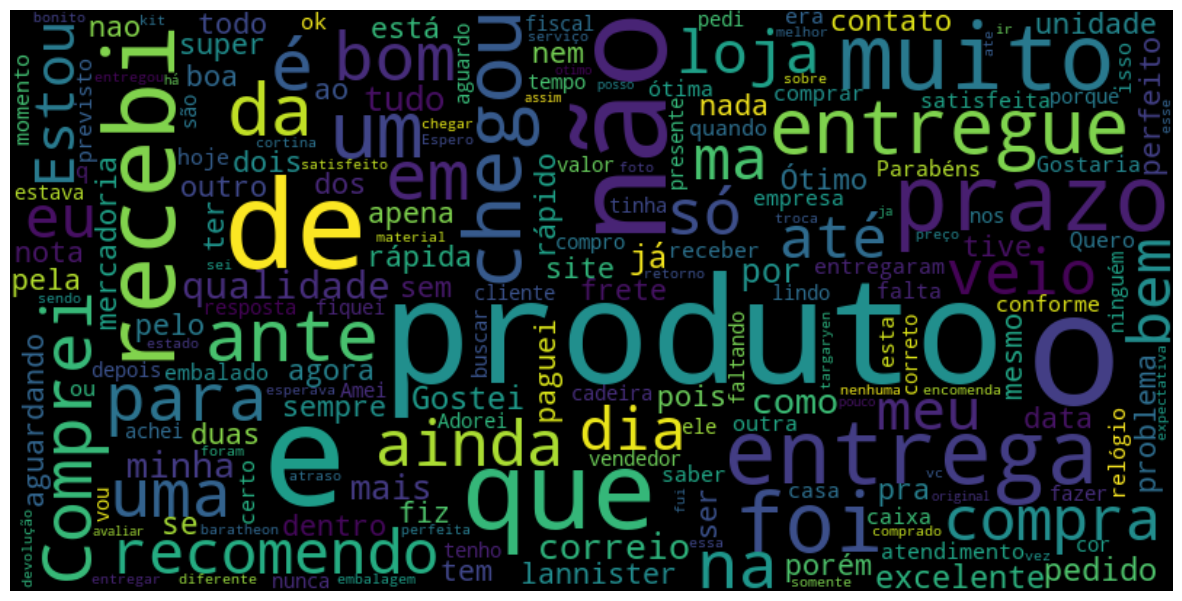

In [63]:
# Nuvem de palavras dos comentários dos clientes do RJ no df_rj
reviews_title_rj = ' '.join(reviews_rj)
wordcloud = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(reviews_title_rj)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [64]:
# Top 3 produtos vendidos para o RJ no df_rj cuja origem é GO
df_rj_go = df_rj[df_rj['seller_state'] == 'GO']
df_rj_go['product_category_name'].value_counts().head(3)


product_category_name
dvds_blu_ray              10
esporte_lazer             10
informatica_acessorios     8
Name: count, dtype: int64

In [65]:
#Principais produtos vendidos para o RJ no df_rj
df_rj['product_category_name'].value_counts().head(10)

product_category_name
cama_mesa_banho           1797
moveis_decoracao          1168
beleza_saude              1112
esporte_lazer             1094
informatica_acessorios    1045
utilidades_domesticas      934
relogios_presentes         888
ferramentas_jardim         696
brinquedos                 602
cool_stuff                 543
Name: count, dtype: int64

In [66]:
# Os titulos dos comentários dos clientes cujo review é 1 no df_rj
reviews_title_1 = df_rj[df_rj['review_score'] == 1]['review_comment_title'].dropna()
reviews_title_1.value_counts().head(20)

review_comment_title
Não recomendo             11
Produto errado            11
Ruim                      10
Entrega incompleta         7
Produto não entregue       6
Não recebi o produto       6
Não recomendo              6
Estou aguardando.          5
Não recebi                 5
Insatisfação               5
PÉSSIMO ATENDIMENTO        5
Bom                        4
Entrega                    4
não recomendo              4
NÃO RECEBI O PRODUTO       4
encomenda                  3
Péssimo                    3
pessimo                    3
produto nao e original     3
Zero nota zero             3
Name: count, dtype: int64

In [67]:
# Os comentários mais frequentes dos clientes cujo review é 1 no df_rj
reviews_1 = df_rj[df_rj['review_score'] == 1]['review_comment_message'].dropna()
reviews_1.value_counts().head(20)


review_comment_message
Não recebi o produto                                                                                                                                                                                            12
Peço por favor verificar a entrega do pedido, pois não recebemos.                                                                                                                                                8
Comprei 6 e só recebi 5.\r\nJá entrei em contato e estou aguardando.. \r\nEspero não ser prejudicada!                                                                                                            6
fiz a compra de 6 cadeiras e so recebi 2, e o stark não se responsabiliza pela mercadoria comprada no site dele um absurdo.                                                                                      6
Comprei seis(6) cadeiras e recebi 4(quatro)                                                                                          

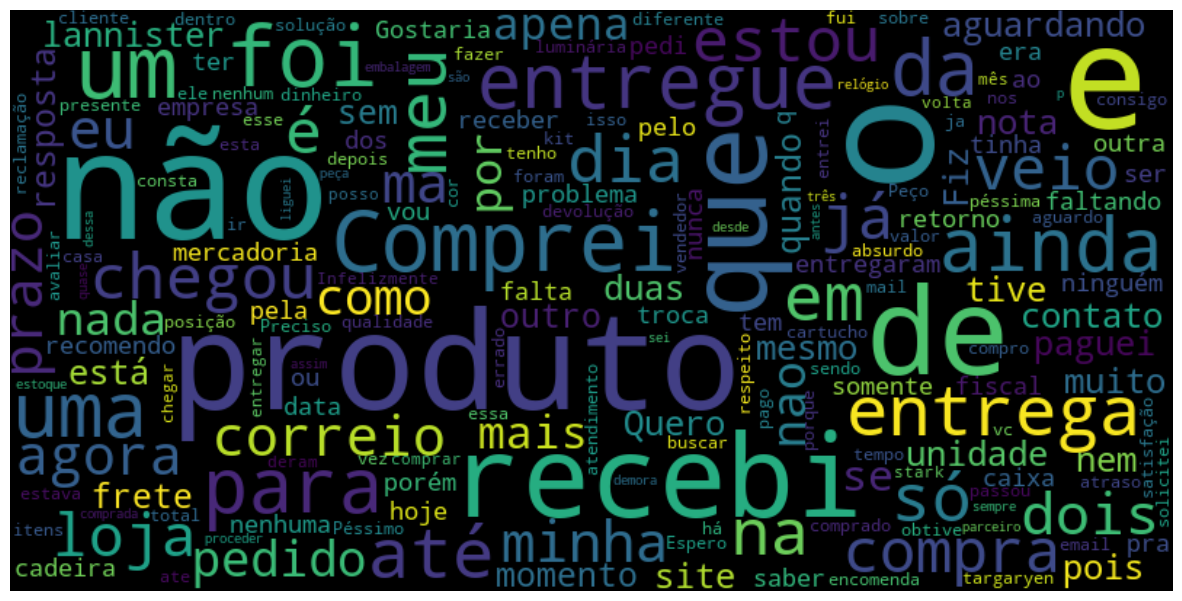

In [71]:
# Nuvem de palavras dos comentários dos clientes cujo review é 1 no df_rj
reviews_1 = ' '.join(reviews_1)
wordcloud = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(reviews_1)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [75]:
# Quanto as vendas de SP com nota 1 para o RJ representam no df_rj
df_rj_sp = df_rj[df_rj['seller_state'] == 'SP']
df_rj_sp_1 = df_rj_sp[df_rj_sp['review_score'] == 1].shape[0]/df_rj.shape[0]*100
df_rj_sp_1

13.004253125402759

In [76]:
# Quanto em valor de vendas totais de SP para o RJ no df_rj com nota 1
df_rj_sp[df_rj_sp['review_score'] == 1]['payment_value'].sum()/df_rj['payment_value'].sum()*100

17.487857692541837

In [77]:
# Tempo médio de entrega de SP para o RJ no df_rj com nota 1
df_rj_sp[df_rj_sp['review_score'] == 1]['tempo_entrega'].mean()


25.789066813914964

In [78]:
# Tempo médio de entrega de SP para o RJ no df_rj
df_rj_sp['tempo_entrega'].mean()

15.701831648483635

In [79]:
# Atraso médio de SP para o RJ no df_rj com nota 1
df_rj_sp[df_rj_sp['review_score'] == 1]['atraso'].mean()

-1.0287134180011044

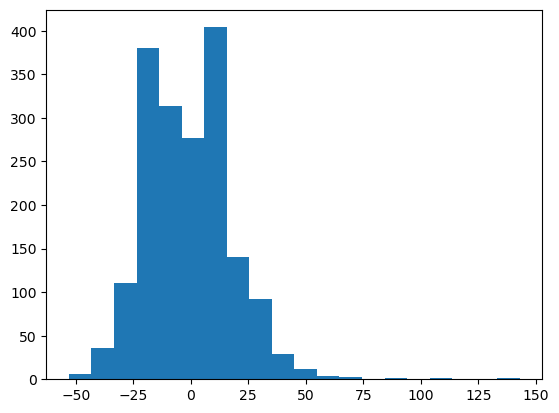

In [80]:
# Plotar um histograma com o atraso de SP para o RJ no df_rj com nota 1
plt.hist(df_rj_sp[df_rj_sp['review_score'] == 1]['atraso'], bins=20)
plt.show()

In [82]:
# Quantas vendas de SP para o RJ no df_rj com nota 1 tem atraso maior que 0
df_rj_sp[df_rj_sp['review_score'] == 1][df_rj_sp['atraso'] > 0].shape[0]/df_rj.shape[0]*100


C:\Users\fidel\AppData\Local\Temp\ipykernel_16216\817117553.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_rj_sp[df_rj_sp['review_score'] == 1][df_rj_sp['atraso'] > 0].shape[0]/df_rj.shape[0]*100


5.548395411779868

In [83]:
# Qual é o atraso médio quando a origem é o RJ no df_rj
df_rj_rj = df_rj[df_rj['seller_state'] == 'RJ']
df_rj_rj['atraso'].mean()

-13.234250221827862

In [84]:
# qual é o atraso médio quando a origem é o SP no df_rj
df_rj_sp['atraso'].mean()

-11.176759083174858

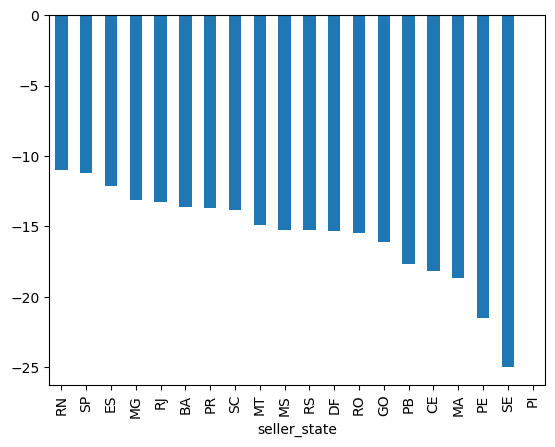

In [86]:
# Plotar um gráfico com atraso médio por estado de origem no df_rj ordenado do maior para o menor
df_rj.groupby('seller_state')['atraso'].mean().sort_values(ascending=False).plot(kind='bar')
plt.show()

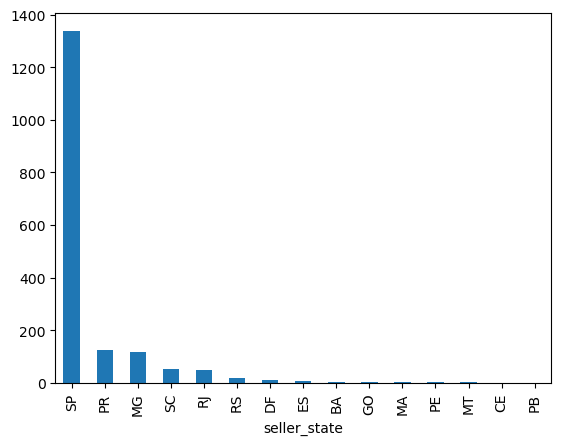

In [87]:
# Plotar o gráfico de quantidade de vendas por estado de origem no df_rj cujo atraso é maior que 0
df_rj[df_rj['atraso'] > 0]['seller_state'].value_counts().plot(kind='bar')
plt.show()
